# Preprocessing and Clustering

Herein is the code that follows the intial preprocessing and clustering pipeline as described by https://www.sc-best-practices.org/preamble.html

This pipeline is the result of much iteration and improvement to correctly capture all aspects of the data.


## Importing

In [1]:
import subprocess

def pip_install(package):
    subprocess.run(["pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

pip_install("dynamo-release")
pip_install("scanpy")

In [1]:
# importing key packages
from dynamo.preprocessing import Preprocessor
from sklearn.decomposition import PCA
import numpy as np
import anndata as ad
import scanpy as sc
from pickle import LONG1
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import drive

/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/usr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Full path to the .h5ad file
file_path = "/content/drive/My Drive/Colab Notebooks/NSC3001/anndata.h5ad"
adata = ad.read_h5ad(file_path)  # Without `backed="r"

In [4]:
adata

AnnData object with n_obs × n_vars = 4840 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count'
    var: 'gene_id', 'gene_name', 'genome'

## Preprocessing

In [5]:
# The final result was to use the dynamo preprocessor package, this was not the intiial intent however, its ease of use and strong results made it the best option
# this was after primarily investigating
# As the data was previously normalised and outlier cells were removed the qc pipeline is minimal herein
# the monocle recipe is recomended by dyn as the best recipe when no spliced data is present
preprocessor = Preprocessor()
preprocessor.preprocess_adata(adata, recipe="monocle")

|-----> Running monocle preprocessing pipeline...
|-----------> filtered out 0 outlier cells
|-----? No layers exist in adata, skipp filtering by shared counts
|-----------> filtered out 39370 outlier genes
|-----? Transforming adata.X from int to float32 for normalization. If you want to disable this, set `transform_int_to_float` to False.
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> [Preprocessor-monocle] completed [77.7523s]


In [6]:
adata

AnnData object with n_obs × n_vars = 4840 × 62710
    obs: 'sample', 'species', 'gene_count', 'tscp_count', 'mread_count', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'Size_Factor', 'initial_cell_size', 'ntr'
    var: 'gene_id', 'gene_name', 'genome', 'nCells', 'nCounts', 'pass_basic_filter', 'score', 'log_cv', 'log_m', 'frac', 'use_for_pca', 'ntr'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean'
    obsm: 'X_pca'

In [7]:
sc.pp.neighbors(adata, n_pcs=26)
sc.tl.umap(adata)


In [8]:
sc.tl.leiden(adata, resolution = 0.23)

<ipython-input-8-c0a89a36df33>:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.23)


### Labelling

Using exsisting sample data I add labels

In [9]:
sample2label = {
    "sample_A1": "iPSC (WT)",
    "sample_B1": "iPSC (HET1)",
    "sample_A2": "LPM (WT)",
    "sample_B2": "LPM (HET1)",
    "sample_A3": "Arterial Pre-MACS (WT)",
    "sample_B3": "Arterial Pre-MACS (HET1)",
    "sample_A4": "Venous Pre-MACS (WT)",
    "sample_B4": "Venous Pre-MACS (HET1)",
    "sample_A5": "Arterial Pure (WT)",
    "sample_B5": "Arterial Pure (HET1)",
    "sample_B6": "Venous Pure (HET1)",
    "sample_C6": "Venous Pure (WT)"
}


In [10]:
adata.obs['cell_identity'] = adata.obs['sample'].map(sample2label).astype('category')


In [11]:
leiden_to_celltype = {
    '0': 'iPSC',
    '1': 'LPM',
    '2': 'Arterial Pre-MACS (HET1)',
    '3': 'Venous Pre-MACS',
    '4': 'Arterial Pre-MACS(WT)',
    '5': 'Arterial Pure (WT)',
    '6': 'Venous Pure (WT)',
    '7': 'Arterial Pure (HET1)',
    '8': 'Venous Pure (HET1)'
}

In [12]:
adata.obs['cluster_identity'] = adata.obs['leiden'].map(leiden_to_celltype).astype('category')

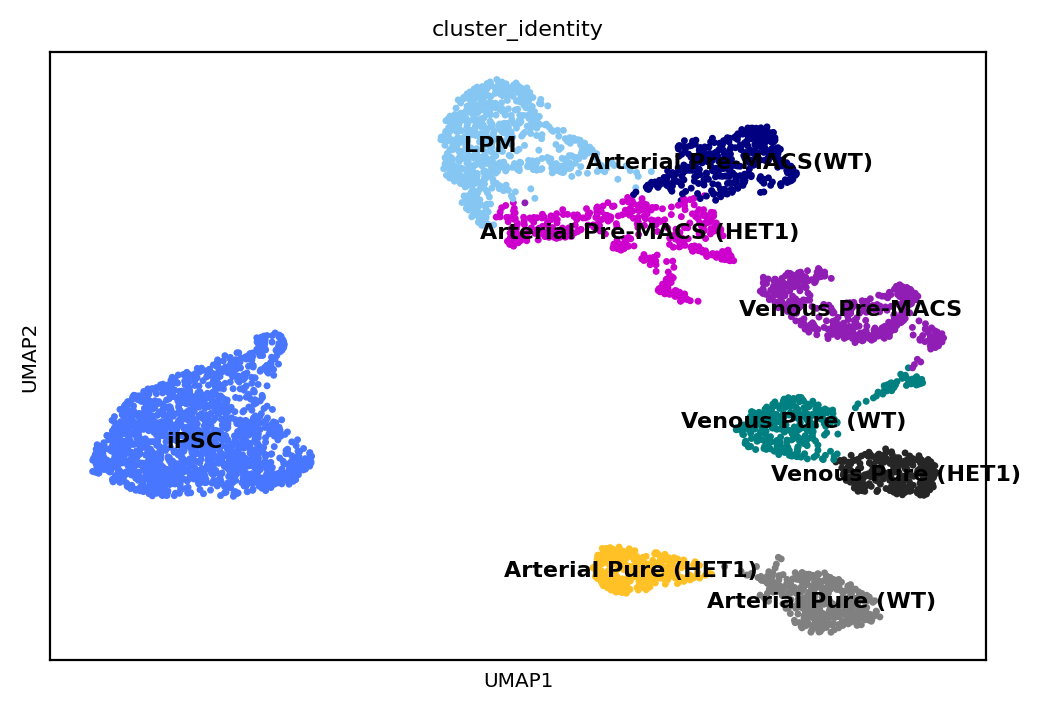

In [13]:
sc.pl.umap(adata, color='cluster_identity', legend_loc='on data')

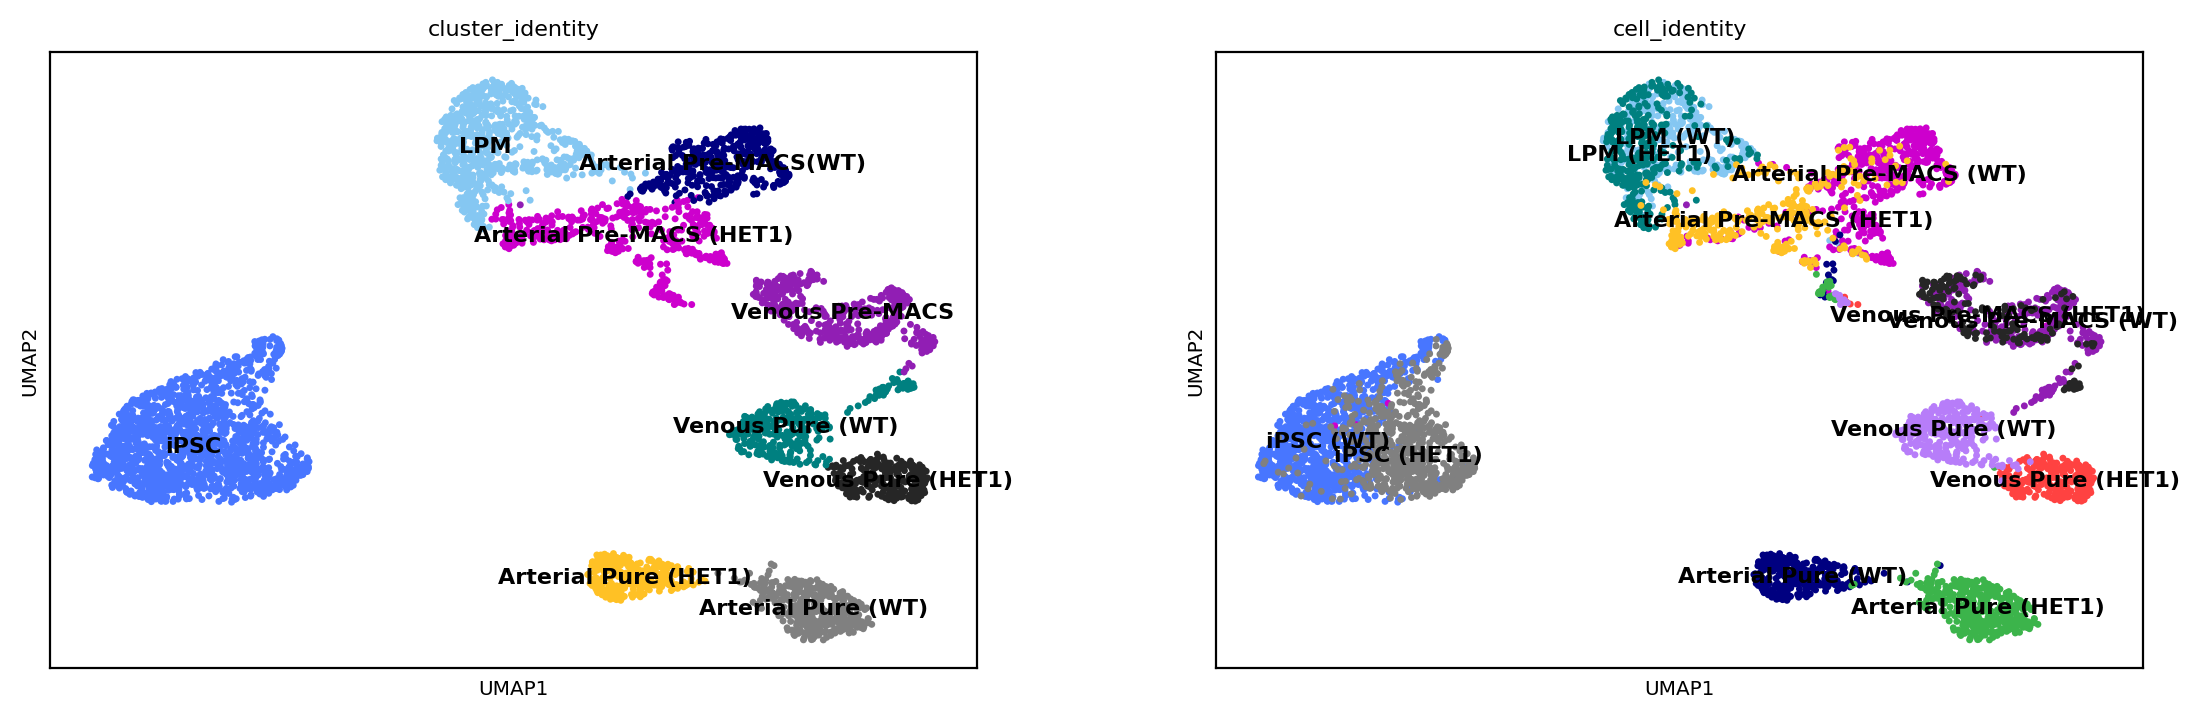

In [15]:
sc.pl.umap(adata, color=['cluster_identity', 'cell_identity'], legend_loc='on data')


### Filtering out a/b 1

this is needed for pseudo temporal applications as iPSC does not fit in dev trajectory
By removing iPSC it will provide:

cleaner pseudotime ordering along the specific developmental paths of interest

Better resolve the bifurcation mechanics between arterial and venous fates

Avoid trajectory distortions from the transcriptionally distinct iPSC state

In [17]:
adata_filtered = adata[~adata.obs['sample'].isin(['sample_A1', 'sample_B1'])]


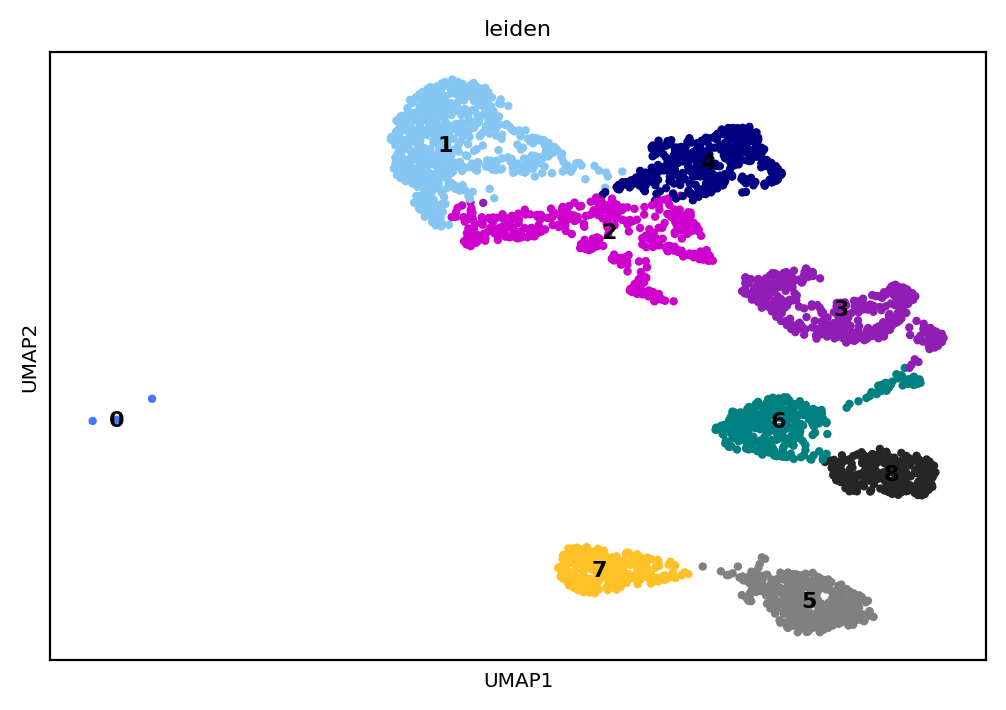

In [18]:
sc.pl.umap(adata_filtered, color='leiden', legend_loc='on data')

In [19]:
#  Re-compute UMAP
sc.pp.neighbors(adata_filtered, n_pcs=30)#29 - 30
sc.tl.umap(adata_filtered)

sc.tl.leiden(adata_filtered, resolution = 0.15)#0.18 - 0.15

# now using lpm as starting point
start_clusters = ['LPM (WT)', 'LPM (HET1)']  # A2, B2 samples

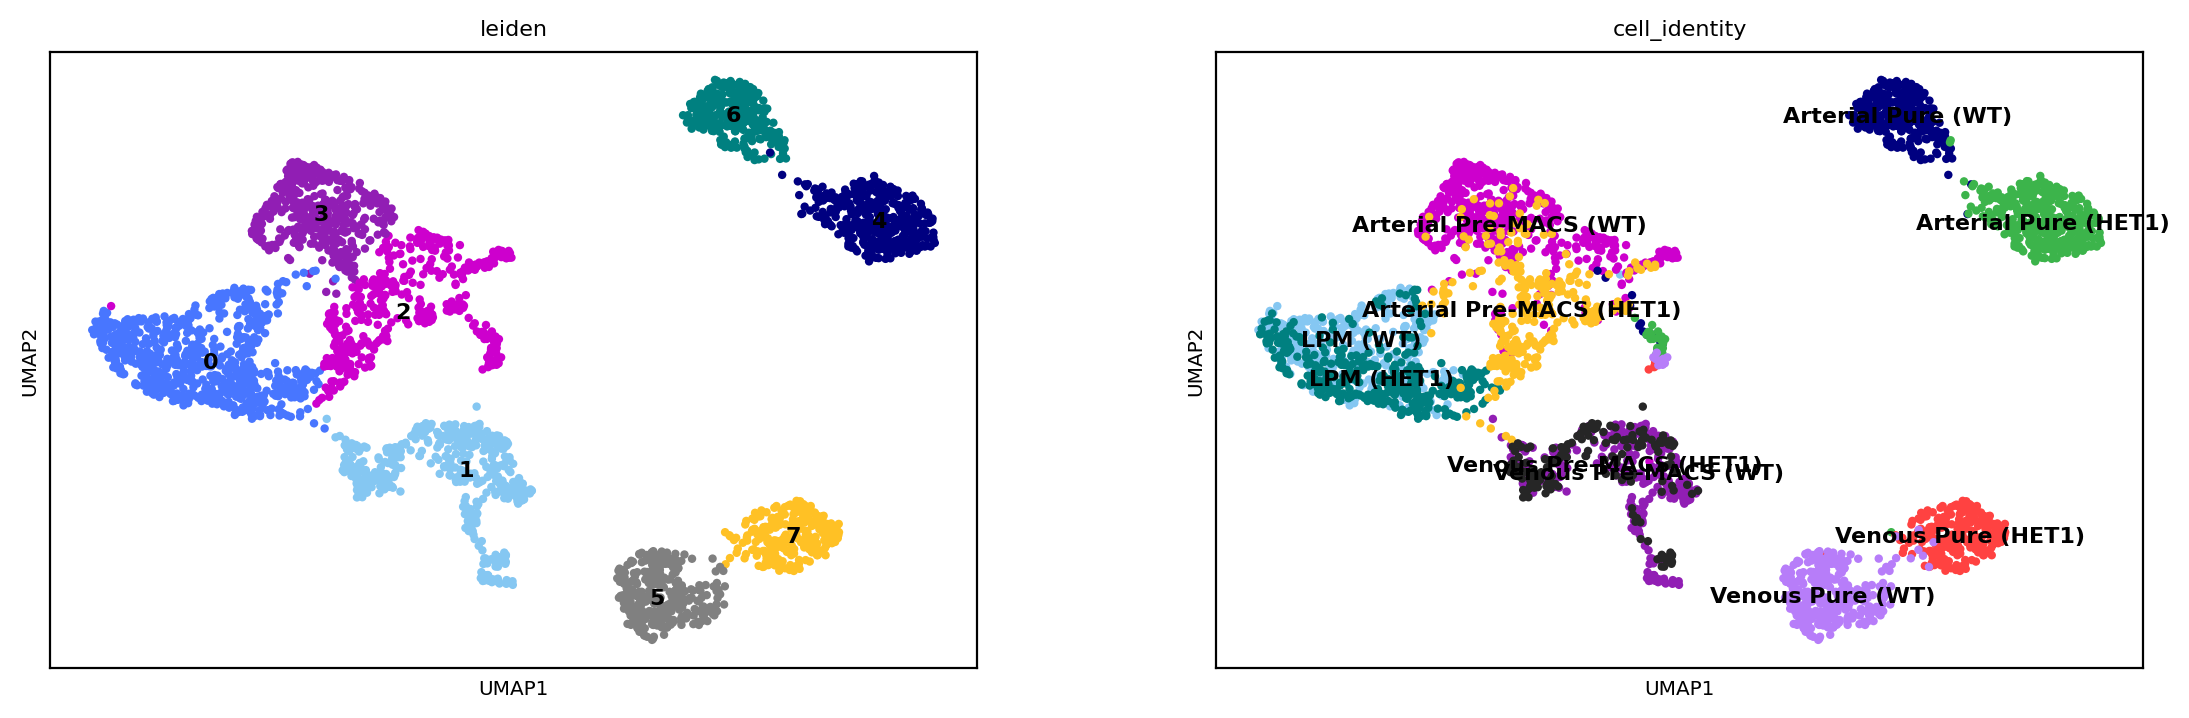

In [20]:
sc.pl.umap(adata_filtered, color=['leiden','cell_identity'], legend_loc='on data')


This demonstrates the clustering to be hihgly succseful, howver there are several key groups that are not disasociated within samples:
Venous Pre-MACS(WT/HET1) are clustered tightly and thus form one cluster, similarly LPM (WT/HET1) are tightly clustered.

In [21]:
leiden_to_celltype_filt = {
    '0': 'LPM',
    '1': 'Venous Pre-MACS',
    '2': 'Arterial Pre-MACS(HET1)',
    '3': 'Arterial Pre-MACS(WT)',
    '4': 'Arterial Pure (HET1)',
    '5': 'Venous Pure (WT)',
    '6': 'Arterial Pure (WT)',
    '7': 'Venous Pure (HET1)'
}

In [22]:
adata_filtered.obs['cluster_identity'] = adata_filtered.obs['leiden'].map(leiden_to_celltype_filt).astype('category')

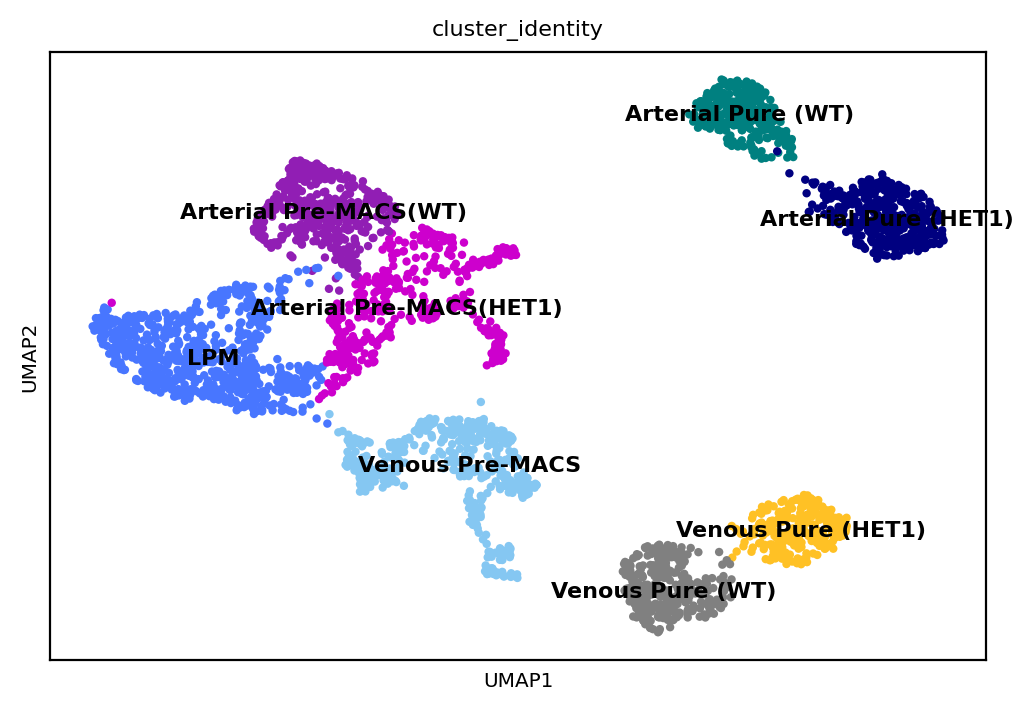

In [23]:
sc.pl.umap(adata_filtered, color='cluster_identity', legend_loc='on data')


# write data out to run pseudotime

In [ ]:
adata_filtered.write_h5ad('/content/drive/My Drive/Colab Notebooks/NSC3001/anndata_processed.h5ad')
